# Create a model architecture based on the Ross et al., 2018

<div>
<img src="model_architecture.png" width="500"/>
</div>


In [1]:
import torch
import torch.nn as nn
from torch.nn import Module

In [2]:
class PolarityPicker(Module):
    def __init__(self):
        super().__init__()
        self.cv1 = nn.Conv1d(in_channels = 1, out_channels=32, kernel_size=21)
        self.cv2 = nn.Conv1d(in_channels = 32, out_channels=64, kernel_size=15)
        self.cv3 = nn.Conv1d(in_channels = 64, out_channels=128, kernel_size=11)
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(128)
        self.pooling = nn.MaxPool1d(kernel_size = 2)
        self.fc1 = nn.Linear(in_features = 114, out_features = 512)
        self.fc2 = nn.Linear(in_features = 512, out_features = 512)
        self.fc3 = nn.Linear(in_features = 65536, out_features = 3)
        self.ft = nn.Flatten()
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, data):
        x = self.cv1(data)
        x = self.bn1(x)
        x = self.pooling(x)
        x = self.cv2(x)
        x = self.bn2(x)
        x = self.pooling(x)
        x = self.cv3(x)
        x = self.bn3(x)
        x = self.pooling(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.fc2(x)
        x = self.bn5(x)
        x = self.ft(x)
        x = self.softmax(self.fc3(x))
        return x  

Check the architecture of the CNN

In [3]:
model = PolarityPicker()

In [4]:
model(torch.rand([1,1,1000]))

tensor([[0.5224, 0.3252, 0.1524]], grad_fn=<SoftmaxBackward0>)

In [5]:
model = PolarityPicker()

# Import the data and plot an example of the waveform

In [6]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [7]:
mat = scipy.io.loadmat ('Wave_ML.mat')
Wave=mat['Wave']
Po=mat['Po']
Po2=mat['Po2'] # have a level of good picks
print(Wave.shape) # this is the wave contains 1000 dots
print(Po.shape)
print(Po2.shape)

(1000, 3820)
(1, 3820)
(1, 3820)


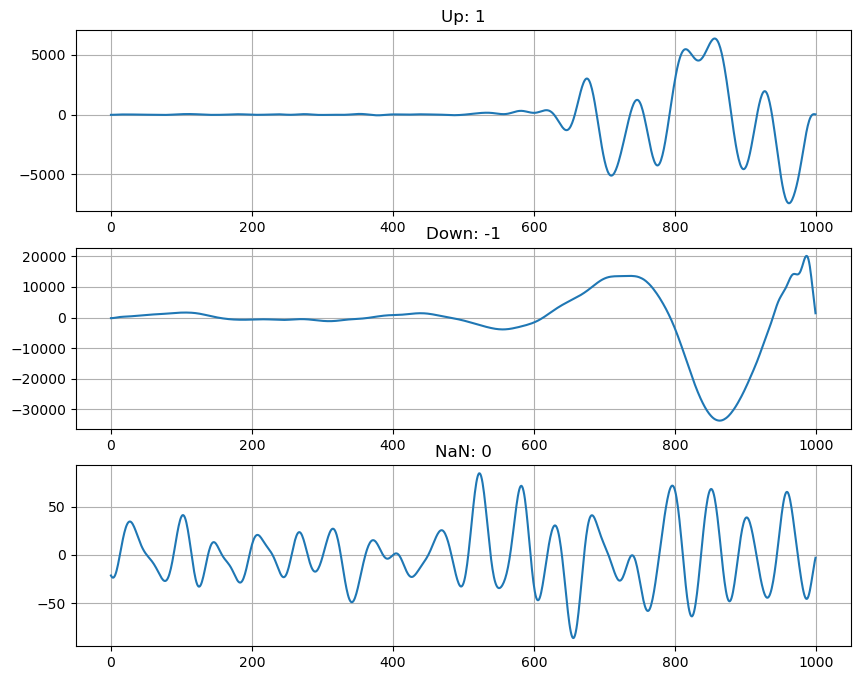

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(10, 8))

axes[0].plot(Wave[:,100])
axes[0].set_title("Up: 1")
axes[0].grid(True)

axes[1].plot(Wave[:,404])
axes[1].set_title("Down: -1")
axes[1].grid(True)

axes[2].plot(Wave[:,49])
axes[2].set_title("NaN: 0")
axes[2].grid(True)

# Normalize data and convert them to 3D tensor

In [9]:
# normalize data and covert it to 3D tensor
Wave_Nor=np.zeros(shape=(Wave.shape[1],1,Wave.shape[0]),dtype=np.float32)
labels=np.zeros(Wave.shape[1])
for iq in range(Wave.shape[1]):
    labels[iq] = Po[0,iq]
    if np.max(np.abs(Wave[iq,:]))>0:
        Wave_Nor[iq,0,:]=(Wave[:,iq])/ np.max(Wave[:,iq])

IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [ ]:
print(Wave_Nor.shape)
print(labels.shape)

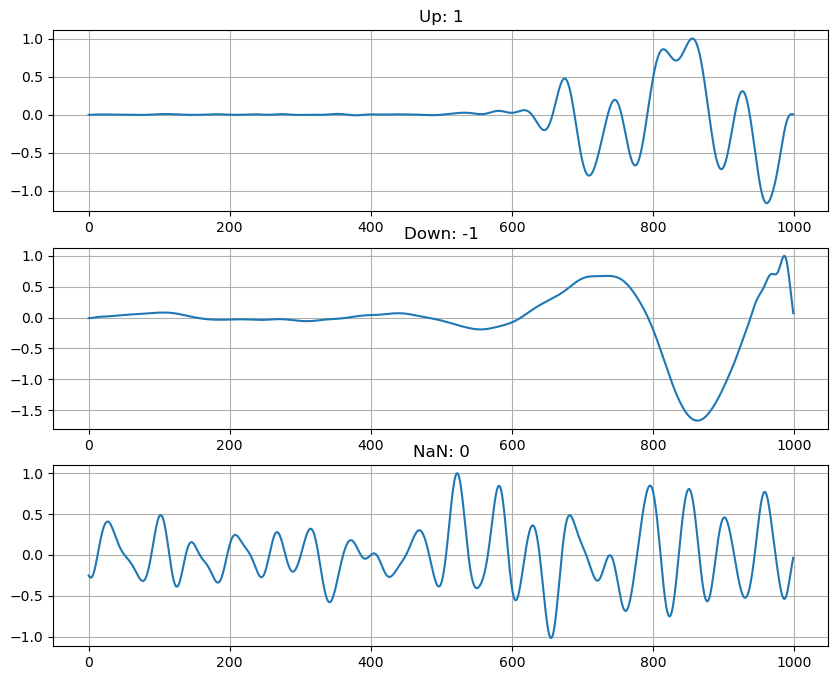

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(10, 8))

axes[0].plot(Wave_Nor[100,0,:])
axes[0].set_title("Up: 1")
axes[0].grid(True)

axes[1].plot(Wave_Nor[404,0,:])
axes[1].set_title("Down: -1")
axes[1].grid(True)

axes[2].plot(Wave_Nor[49,0,:])
axes[2].set_title("NaN: 0")
axes[2].grid(True)

In [11]:
Wave_Nor.shape

(3820, 1, 1000)

In [12]:
# right now the data is organized as the first set being earthquakes, the other set being noise.
# we need to reshuffle the indexes to avoid biasas.
ind=np.arange(Wave_Nor.shape[0])
np.random.shuffle(ind) # shuffle indexes in place
Wave2 = Wave_Nor[ind,:,:]
labels2 = labels[ind]
Wave2.shape
#plt.plot(Wave2[:,:,1])

(3820, 1, 1000)

Convert data from numpy array to Torch

In [13]:
# Dataset is a class already defined in PyTorch. 
# We are going to create a subclass of Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
class ZipDataset(Dataset):
    def __init__(self, seismograms, labels=None, transforms=None):
        # Let us define the attributes of a ZipDataset
        self.X = seismograms # that will be train_images or test_images
        self.y = labels # that will be train_labels or test_labels
        # When we create an object of class ZipDataset, we can specify the transformation to apply to the data 
        self.transforms = transforms
         
    def __len__(self):
        # The length of the dataset is the number of images in the dataset
        return (len(self.X))
    
    def __getitem__(self, i):
        # How to access one pair of (image, label) from the dataset?
        # We access the ith row (which contains the 16*16 = 256 pixels of an image)
        data = self.X[i, :, :]
        # We apply the required transformation to the image
        if self.transforms:
            data = self.transforms(data)
            # data=data[:,:,:,None]
            # torch.unsqueeze(data,dim=1)
            torch.squeeze(data)
        # If there is a label associated to it, we return it together with the image
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

In [14]:
labels3 = labels2 + 1
labels3

array([1., 1., 0., ..., 2., 1., 1.])

In [15]:
dataset = ZipDataset(Wave2, labels3)
X,y=dataset[0]
X=X.float()
print(X.size(), torch.squeeze(X).size(), y)

AttributeError: 'numpy.ndarray' object has no attribute 'float'

# Split train and validation data set

In [31]:
L=len(dataset)
L

3820

In [32]:
from torch.utils.data import Dataset, DataLoader
L=len(dataset)
print(L)
Lt = int(0.8*L)
train_set, val_set = torch.utils.data.random_split(dataset, [Lt,L-Lt], generator=torch.Generator().manual_seed(11))
# print(train_set[121], train_set[0])
# sum1=torch.sum(train_set[121][0])
# sum2=torch.sum(train_set[0][0])

3820


In [33]:
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
loaded_train = DataLoader(train_set, batch_size=480)
loaded_test = DataLoader(val_set, batch_size=480)
X, y = next(iter(loaded_train))
print(X.size())

torch.Size([480, 1, 1000])


In [18]:
torch.nn.Softmax(model(torch.rand([480, 1, 1000])))

Softmax(
  dim=tensor([[0.2789, 0.3758, 0.3452],
          [0.3502, 0.3015, 0.3484],
          [0.3736, 0.4052, 0.2212],
          ...,
          [0.2924, 0.4707, 0.2369],
          [0.3747, 0.0897, 0.5356],
          [0.3353, 0.2039, 0.4608]], grad_fn=<SoftmaxBackward0>)
)

In [19]:
loaded_train

# Train the data ?
We again train this CNN using the Adam optimization algorithm, but using a cross-entropy loss function. A learning rate of 0.001 is used to train the CNN in batches of 480, for 8 epochs, with a patience value of 5.

These labeled samples are then used to train the second CNN with the same architecture as the pick time CNN, except that for this network the final output layer is replaced with a softmax activation function (classifier)


In [20]:
def train(model, n_epochs, trainloader, testloader=None,learning_rate=0.001 ):

    os.makedirs('PolarityPicker',exist_ok=True)
    # Define loss and optimization method
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    # # Save loss and error for plotting
    loss_time = np.zeros(n_epochs)
    accuracy_time = np.zeros(n_epochs)

    # # Loop on number of epochs
    for epoch in range(n_epochs):
    #     # Initialize the loss
        running_loss = 0
    #     # Loop on samples in train set
        for data in trainloader:
    #         # Get the sample and modify the format for PyTorch
            inputs, labels = data[0], data[1]
            # inputs, labels = torch.squeeze(data[0]), data[1]
            inputs = inputs.float()
            labels = labels.long()
    #         # Set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
    #         # Propagate the loss backward
            loss.backward()
    #         # Update the gradients
            optimizer.step()
    #         # Add the value of the loss for this sample
            running_loss += loss.item()
    #     # Save loss at the end of each epoch
        loss_time[epoch] = running_loss/len(trainloader)

        
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
                        }
        
        f_path = './PolarityPicker/checkpoint.pt'
        torch.save(checkpoint, f_path)

        
    #     # After each epoch, evaluate the performance on the test set
        if testloader is not None:
            correct = 0
            total = 0
    #         # We evaluate the model, so we do not need the gradient
            with torch.no_grad(): # Context-manager that disabled gradient calculation.
    #             # Loop on samples in test set
                for data in testloader:
    #                 # Get the sample and modify the format for PyTorch
                    inputs, labels = data[0], data[1]
                    # inputs, labels = torch.squeeze(data[0]), data[1]
                    inputs = inputs.float() 
                    # torch.squeeze(inputs,dim=0)
                    labels = labels.long()
    #                 # Use model for sample in the test set
                    outputs = model(inputs)
    #                 # Compare predicted label and true label
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
    #         # Save error at the end of each epochs
            accuracy_time[epoch] = 100 * correct / total
    
    #     # Print intermediate results on screen
        if testloader is not None:
            print('[Epoch %d] loss: %.3f - accuracy: %.3f' %
              (epoch + 1, running_loss/len(trainloader), 100 * correct / total))
        else:
            print('[Epoch %d] loss: %.3f' %
              (epoch + 1, running_loss/len(trainloader)))

    # # Save history of loss and test error
    if testloader is not None:
        return (loss_time, accuracy_time)
    else:
        return (loss_time)
        

In [21]:
import os
if not os.path.exists('./PolarityPicker_checkpoint'):
  os.mkdir('./PolarityPicker_checkpoint')
(loss, accuracy) = train(model, 10, loaded_train, loaded_test, 6e-4)

[Epoch 1] loss: 0.731 - accuracy: 89.005
[Epoch 2] loss: 0.651 - accuracy: 90.838
[Epoch 3] loss: 0.645 - accuracy: 93.455
[Epoch 4] loss: 0.639 - accuracy: 93.979
[Epoch 5] loss: 0.624 - accuracy: 94.241
[Epoch 6] loss: 0.625 - accuracy: 93.063
[Epoch 7] loss: 0.628 - accuracy: 92.801
[Epoch 8] loss: 0.629 - accuracy: 92.670
[Epoch 9] loss: 0.628 - accuracy: 93.194
[Epoch 10] loss: 0.621 - accuracy: 93.979


In [22]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix

In [23]:
for i in loaded_train:
    X = i[0]
    y = i[1]
    break

In [29]:
X.shape

torch.Size([480, 1, 1000])

In [24]:
predict = model(X)

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<AxesSubplot: >

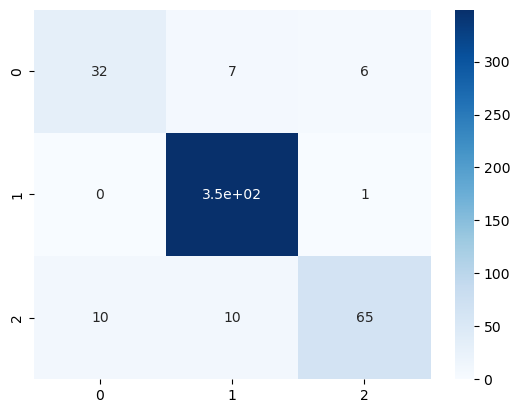

In [28]:
sns.heatmap(confusion_matrix(np.argmax(predict.detach().numpy(), axis = 1), y), annot = True, cmap = 'Blues')

In [313]:
history = model.fit(X_train,Y_train,epochs=100,batch_size=100,validation_data=(X_val,Y_val))

AttributeError: 'PolarityPicker' object has no attribute 'fit'

10


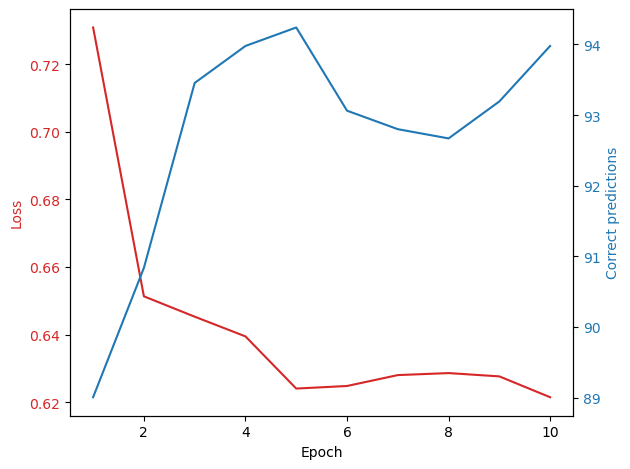

In [27]:
fig, ax1 = plt.subplots()
print(len(loss))
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(1, len(loss)+1), loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Correct predictions', color=color)
ax2.plot(np.arange(1, len(accuracy)+1), accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

## Examples

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 1. Gather and preprocess the data
X, y = load_data()  # Load the earthquake waveform data and labels
X = preprocess(X)  # Apply transformations such as padding, resampling, and normalizing

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 3. Define the CNN model architecture
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(32, 5, padding='same', activation='relu', input_shape=(1000, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

# 4. Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 5. Train the model on the training set
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# 6. Evaluate the performance of the trained model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# 7. Use the trained model to pick the first motion polarity of new waveforms
predictions = model.predict(X_new)  # X_new is a numpy array of new, unseen waveform data


In [ ]:
# Load earthquake wave data and corresponding first motion polarities
import pandas as pd
waves = pd.read_csv('earthquake_waves.csv')

# Preprocess the data
waves['wave'] = (waves['wave'] - waves['wave'].mean()) / waves['wave'].std()  # Normalize wave amplitudes
waves['wave'] = bandpass(waves['wave'], 1, 10, 20)  # Apply bandpass filter
train, val, test = np.split(waves, [int(0.7 * len(waves)), int(0.85 * len(waves))])  # Split into train, val, and test sets

# Define the CNN architecture
model = Sequential()
model.add(InputLayer(input_shape=(64, 1)))
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

# Train the CNN
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train['wave'], train['polarity'], batch_size=32, epochs=10, validation_data=(val['wave'], val['polarity']))

# Evaluate the trained model on the test set
predictions = model.predict(test['wave'])
accuracy = np.mean(predictions == test['polarity'])
print(accuracy)
